In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
file = '/Users/kiening/Documents/Dissertation/dissertation.cb_companies.json'

with open(file, 'r', encoding='utf-8') as file:
    data = json.load(file)


In [3]:
def whether_success(data):
    for i in data:
        i ['startup'] = 'failed'
        if i['operating_status'] != 'closed':
            if i['went_public_on']:
                i['startup'] = 'success'
            elif i['status'] == 'was_acquired' or 'ipo':
                i['startup'] = 'success'
            elif (datetime.now() - datetime.strptime(i['founded_on'], '%Y-%m-%d')).days/365 >= 5:
                i['startup'] = 'success'
            elif i['num_funding_rounds'] >= 5:
                i['startup'] = 'success'
            elif i['equity_funding_total_usd'] >= 100000000:
                i['startup'] = 'success'
    return data

In [6]:
def build_nw(comps, peo):
    G = nx.Graph()
    G.add_nodes_from(comps)
    
    peo_dict = {comp: set(p) for comp, p in zip(comps, peo)}
    
    def process_pairs(i, comp):
        edges = []
        for j in range(i+1, len(comps)):
            same = peo_dict[comp] & peo_dict[comps[j]]
            if same:
                edges.append((comp, comps[j], len(same)))
        return edges

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_pairs, i, comp) for i, comp in enumerate(comps)]
        for future in as_completed(futures):
            for comp1, comp2, weight in future.result():
                if G.has_edge(comp1, comp2):
                    G[comp1][comp2]['weight'] += weight
                else:
                    G.add_edge(comp1, comp2, weight=weight)

    return G


In [7]:
# Read data here
comps = []
peo = []
for com in data[:10000]:
    comps.append(com['name'])
    peo.append(list(set(com['founders']) | set(com['investors'])))


In [10]:
len(comps)

10000

In [5]:
G = build_nw(comps, peo)

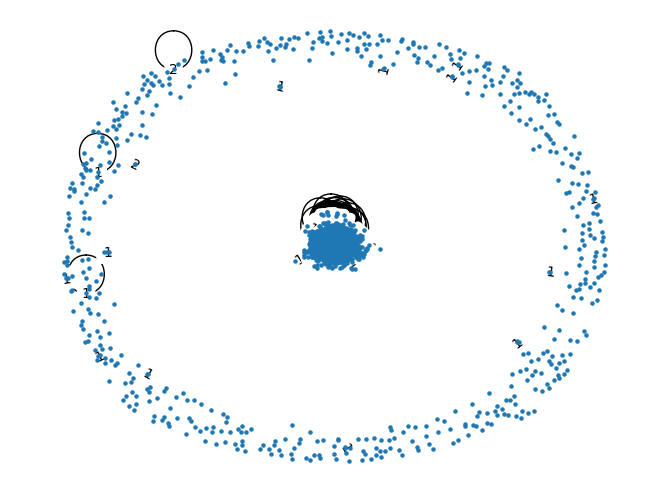

In [7]:
# Draw network here
#nx.draw(G, with_labels=True)

pos = nx.spring_layout(G)
nx.draw(G, 
        pos, 
        with_labels=False, 
        node_size=5, 
        font_size=5)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [8]:
def generate_data(G):
    net_nodes = len(G.nodes())
    net_edges = len(G.edges())
    net_den = round(nx.density(G),4)
    avg_cluster = round(nx.average_clustering(G),4)
    avg_degree = round(np.mean(list(dict(G.degree()).values())),4)
    max_degree = max(list(dict(G.degree()).values()))
    min_degree = min(list(dict(G.degree()).values()))
    total_strength = 0
    for node in G.nodes():
        node_strength = sum(data["weight"] for u, v, data in G.edges(node, data=True))
        total_strength += node_strength
    avg_strength = round(total_strength / net_nodes, 4)
    try:
        net_assortativity = round(nx.degree_assortativity_coefficient(G),4)
    except RuntimeWarning:
        net_assortativity = None

    table ={
        "Number of Nodes": net_nodes,
        "Number of Edges": net_edges,
        "Density": net_den,
        "Avg Clustering Coefficient": avg_cluster,
        "Avg Degree": avg_degree,
        "Max Degree": max_degree,
        "Min Degree": min_degree,
        "Avg Strength": avg_strength,
        "Assortativity": net_assortativity}    
    return table

In [9]:
analysis = generate_data(G)
analysis

{'Number of Nodes': 9899,
 'Number of Edges': 566784,
 'Density': 0.0116,
 'Avg Clustering Coefficient': 0.4803,
 'Avg Degree': 114.5134,
 'Max Degree': 1091,
 'Min Degree': 0,
 'Avg Strength': 121.034,
 'Assortativity': 0.5646}

In [3]:
data[1].keys()

dict_keys(['_id', 'uuid', 'categories', 'category_groups', 'cb_created_at', 'cb_updated_at', 'created_at', 'equity_funding_total_usd', 'facet_ids', 'founded_on', 'founders', 'funding_stage', 'funding_total_usd', 'investor_stage', 'investors', 'last_equity_funding_total_usd', 'last_equity_funding_type', 'last_funding_date', 'last_funding_total_usd', 'last_funding_type', 'location_groups', 'locations', 'name', 'num_acquisitions', 'num_employees_enum', 'num_funding_rounds', 'operating_status', 'owner', 'rank_org', 'rank_principal', 'revenue_range', 'short_description', 'status', 'updated_at', 'valuation_usd', 'version', 'exited_on', 'investor_type', 'metadata', 'went_public_on'])

In [7]:
len(data)

300001